# 🛠️ Feature Engineering & Selection

> **V3 Notebook 02**  
> optimizing features for the V3 model: removing redundancy, encoding, and selection.

---

| Action | Description |
|--------|-------------|
| **Redundancy Removal** | Dropping 8 perfectly correlated features |
| **Feature Selection** | Keeping 31 recommended features |
| **Encoding** | Cyclical encoding for time, one-hot for conditions |

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
pd.set_option('display.max_columns', 50)
print('✅ Libraries loaded!')

✅ Libraries loaded!


In [2]:
# Load cleaned dataset
DATA_PATH = Path('../../data/processed/weather_v3_cleaned.csv')
df = pd.read_csv(DATA_PATH)

print(f'📊 Loaded: {df.shape[0]:,} rows × {df.shape[1]} columns')

📊 Loaded: 114,203 rows × 41 columns


---
## ✂️ Step 1: Remove Redundant Features

Removing features with > 0.95 correlation (e.g., Fahrenheit, mph vs kph).

In [3]:
DROP_COLS = [
    'temperature_fahrenheit', 'feels_like_fahrenheit',
    'wind_mph', 'gust_mph', 'precip_in', 'pressure_in',
    'visibility_miles', 'air_quality_gb-defra-index',
    'air_quality_PM10', 'air_quality_us-epa-index',
    'location_name', 'timezone', 'moonrise', 'moonset',
    'moon_illumination', 'last_updated'
]

# Drop columns that exist
cols_to_drop = [c for c in DROP_COLS if c in df.columns]
df_v3 = df.drop(columns=cols_to_drop)

print(f'✂️ Dropped {len(cols_to_drop)} columns')
print(f'📊 New Shape: {df_v3.shape[0]:,} rows × {df_v3.shape[1]} columns')

✂️ Dropped 16 columns
📊 New Shape: 114,203 rows × 25 columns


---
## 🔄 Step 2: Temporal Feature Engineering

Converting time strings to cyclical features (sin/cos) for month and day.

In [4]:
# Convert epoch to datetime
df_v3['date'] = pd.to_datetime(df_v3['last_updated_epoch'], unit='s')

# Extract basic components
df_v3['month'] = df_v3['date'].dt.month
df_v3['day_of_year'] = df_v3['date'].dt.dayofyear
df_v3['hour'] = df_v3['date'].dt.hour

# Cyclical Encoding
def cyclize(data, max_val):
    sin_feat = np.sin(2 * np.pi * data / max_val)
    cos_feat = np.cos(2 * np.pi * data / max_val)
    return sin_feat, cos_feat

df_v3['month_sin'], df_v3['month_cos'] = cyclize(df_v3['month'], 12)
df_v3['day_year_sin'], df_v3['day_year_cos'] = cyclize(df_v3['day_of_year'], 366)
df_v3['hour_sin'], df_v3['hour_cos'] = cyclize(df_v3['hour'], 24)

print('✅ Created cyclical time features')

✅ Created cyclical time features


---
## 🌍 Step 3: Geographic Feature Engineering

Normalizing latitude and encoding hemisphere.

In [5]:
# Geographic features
df_v3['hemisphere_encoded'] = (df_v3['latitude'] >= 0).astype(int)
df_v3['abs_latitude'] = df_v3['latitude'].abs()
df_v3['latitude_normalized'] = df_v3['abs_latitude'] / 90.0

print('✅ Created geographic features')

✅ Created geographic features


---
## 🔍 Step 4: Correlation Analysis

Checking correlations of selected features with Temperature.

In [6]:
# Select numeric columns for correlation
numeric_cols = df_v3.select_dtypes(include=[np.number]).columns
corr = df_v3[numeric_cols].corr()['temperature_celsius'].sort_values(ascending=False)

print('🌡️ Top 10 Positive Correlations:')
print(corr.head(10))
print('\n🌡️ Top 10 Negative Correlations:')
print(corr.tail(10))

🌡️ Top 10 Positive Correlations:
temperature_celsius    1.000000
feels_like_celsius     0.980462
uv_index               0.485948
air_quality_Ozone      0.277902
hour                   0.171640
longitude              0.148917
visibility_km          0.087238
wind_kph               0.085764
gust_kph               0.084154
air_quality_PM2.5      0.044845
Name: temperature_celsius, dtype: float64

🌡️ Top 10 Negative Correlations:
air_quality_Nitrogen_dioxide   -0.158573
cloud                          -0.163670
hour_sin                       -0.176900
pressure_mb                    -0.307690
latitude                       -0.318405
month_cos                      -0.322548
humidity                       -0.349517
day_year_cos                   -0.355038
latitude_normalized            -0.525200
abs_latitude                   -0.525200
Name: temperature_celsius, dtype: float64


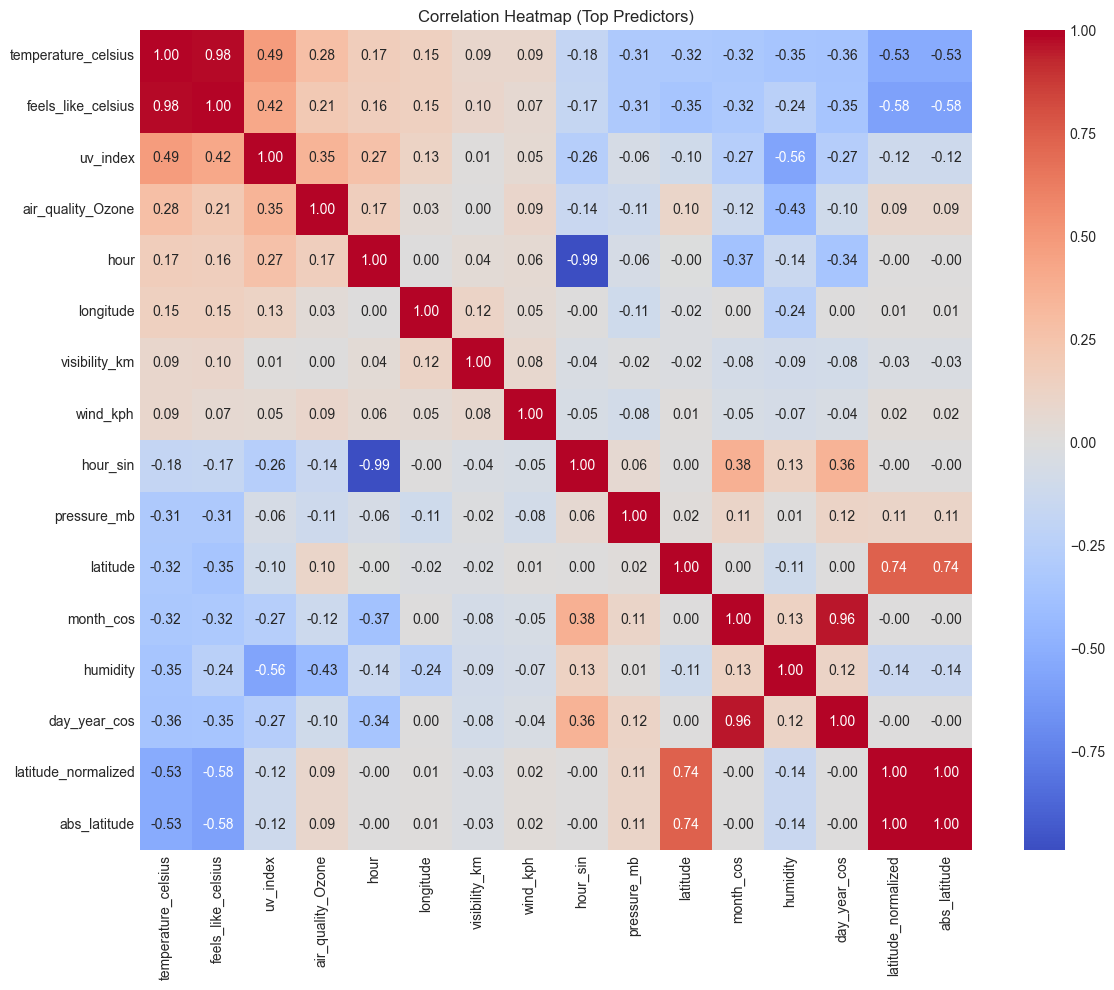

In [7]:
# Correlation Heatmap for Top Features
top_corr_features = corr.head(8).index.tolist() + corr.tail(8).index.tolist()
subset_corr = df_v3[top_corr_features].corr()

fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(subset_corr, annot=True, fmt='.2f', cmap='coolwarm', center=0, ax=ax)
ax.set_title('Correlation Heatmap (Top Predictors)')
plt.tight_layout()
plt.show()

---
## 💾 Save Engineered Dataset

Saving the final dataset ready for model training.

In [8]:
# Drop intermediate date column if not needed
if 'date' in df_v3.columns:
    df_v3 = df_v3.drop(columns=['date'])

OUTPUT_PATH = Path('../../data/processed/weather_v3_ready.csv')
df_v3.to_csv(OUTPUT_PATH, index=False)

print(f'✅ Saved final dataset: {OUTPUT_PATH}')
print(f'📊 Final Features ({len(df_v3.columns)}):')
print(df_v3.columns.tolist())

✅ Saved final dataset: ..\..\data\processed\weather_v3_ready.csv
📊 Final Features (37):
['country', 'latitude', 'longitude', 'last_updated_epoch', 'temperature_celsius', 'condition_text', 'wind_kph', 'wind_degree', 'wind_direction', 'pressure_mb', 'precip_mm', 'humidity', 'cloud', 'feels_like_celsius', 'visibility_km', 'uv_index', 'gust_kph', 'air_quality_Carbon_Monoxide', 'air_quality_Ozone', 'air_quality_Nitrogen_dioxide', 'air_quality_Sulphur_dioxide', 'air_quality_PM2.5', 'sunrise', 'sunset', 'moon_phase', 'month', 'day_of_year', 'hour', 'month_sin', 'month_cos', 'day_year_sin', 'day_year_cos', 'hour_sin', 'hour_cos', 'hemisphere_encoded', 'abs_latitude', 'latitude_normalized']


---
## ✅ Summary

**Next Steps**: [03_v3_model_training.ipynb](03_v3_model_training.ipynb) - Train the V3 Model!